## Decision Tree Model

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSC-680 Capstone/output/sample_data_modeling.csv')

In [4]:
df['click_time'] = pd.to_datetime(df['click_time'])
df['click_date'] = pd.to_datetime(df['click_date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55249 entries, 0 to 55248
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ip                        55249 non-null  int64         
 1   app                       55249 non-null  int64         
 2   device                    55249 non-null  int64         
 3   os                        55249 non-null  int64         
 4   channel                   55249 non-null  int64         
 5   click_time                55249 non-null  datetime64[ns]
 6   is_attributed             55249 non-null  int64         
 7   click_date                55249 non-null  datetime64[ns]
 8   median_time_diff_app      55249 non-null  float64       
 9   median_time_diff_channel  55249 non-null  float64       
 10  hour                      55249 non-null  int64         
 11  minute                    55249 non-null  int64         
 12  hour_0_to_8       

In [6]:
df['is_attributed'].value_counts()

0    46184
1     9065
Name: is_attributed, dtype: int64

### Create Training and Test sets

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [8]:
X = df[['median_time_diff_app', 'median_time_diff_channel',
        'hour_0_to_8', 'hour_8_to_16',
        'hour_16_to_24', 'app_encoded',
        'channel_encoded', 'os_encoded', 'device_encoded', 'ctr']]

In [9]:
feature_names = X.columns
feature_names

Index(['median_time_diff_app', 'median_time_diff_channel', 'hour_0_to_8',
       'hour_8_to_16', 'hour_16_to_24', 'app_encoded', 'channel_encoded',
       'os_encoded', 'device_encoded', 'ctr'],
      dtype='object')

In [10]:
y = df['is_attributed']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [12]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (41436, 10)
X_test shape: (13813, 10)


### Feature Selection

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

In [14]:
# create Pipeline
sfs = SequentialFeatureSelector(estimator=DecisionTreeClassifier(), n_features_to_select=5)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                          n_features_to_select=5)

In [15]:
feature_names_new = feature_names[sfs.get_support()]
feature_names_new

Index(['hour_8_to_16', 'hour_16_to_24', 'channel_encoded', 'device_encoded',
       'ctr'],
      dtype='object')

In [16]:
X_new = X[feature_names_new]

In [17]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, random_state=1)

### GridSearch Cross Validation (GridSearchCV)
Use a grid search cross-validation on new features for selection of the optimal parameters. Exhaustive search for optimal set of parameters that produce the best score for the model.  Several iterations of cross validation for every combination of parameter values.

GridSearchCV tries all possible combinations of the specified parameters. Therefore, adding more parameters to your grid exponentially increases the number of models that need to be built.

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {'max_depth': [2, 3, 4, 5] }

In [20]:
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
grid.fit(X_train_new, y_train_new)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test_new, y_test_new)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 1.00
Test set score: 1.00
Best parameters: {'max_depth': 3}


In [21]:
max_depth = grid.best_params_['max_depth']
max_depth

3

### Cross Validation

In [22]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [23]:
print(f'X_new.shape: {X_new.shape}')

X_new.shape: (55249, 5)


In [24]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(DecisionTreeClassifier(max_depth=max_depth), X_train_new, y_train_new, cv=s_kfold)
scores

array([0.99698359, 0.99686256, 0.99589719, 0.99758658, 0.99686256])

In [25]:
scores.mean()

0.9968384944228132

### Evaluate on Test data set

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [27]:
def eval_decision_tree():
  '''
  Fit Decision Tree to training set and evaulate against test set.

  returns:
    y_true: true values
    y_pred: predictions
  '''
  tree_test = DecisionTreeClassifier(max_depth=max_depth)
  tree_test.fit(X_train_new, y_train_new)

  y_true = y_test_new
  y_pred = tree_test.predict(X_test_new)

  return y_true, y_pred, tree_test

In [28]:
def display_confusion_matrix(cm, title, tree_test):
  '''
  Plot confusion matrix

  params:
    cm: confusion matrix
  '''
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_test.classes_)

  fig, ax = plt.subplots(figsize=(5,4))
  ax.set_title(title)
  disp.plot(ax=ax, cmap='Blues')
  plt.show()

In [29]:
def print_classification_report(cm):
  '''
  Print classification report

  params:
    cm: confusion matrix
  '''
  tn, fp, fn, tp = cm.ravel()
  accuracy = (tp + tn) / (tp + fp + tn + fn)
  print(f"Accuracy: {accuracy}")

  print(f'True negatives: {tn}')
  print(f'False positives: {fp}')
  print(f'False negatives: {fn}')
  print(f'True positives: {tp}')

  print(classification_report(y_true, y_pred))

In [30]:
y_true, y_pred, tree_test = eval_decision_tree()

In [31]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[11534,    14],
       [   21,  2244]])

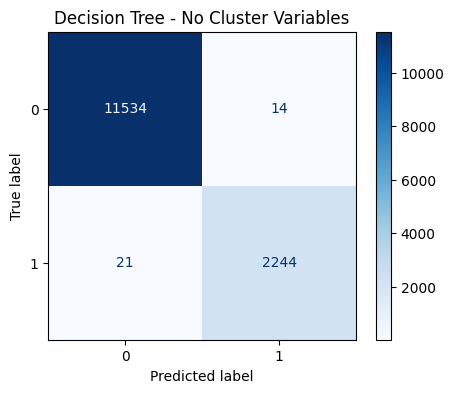

In [32]:
display_confusion_matrix(cm, 'Decision Tree - No Cluster Variables', tree_test)

In [33]:
print_classification_report(cm)

Accuracy: 0.9974661550713096
True negatives: 11534
False positives: 14
False negatives: 21
True positives: 2244
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11548
           1       0.99      0.99      0.99      2265

    accuracy                           1.00     13813
   macro avg       1.00      0.99      1.00     13813
weighted avg       1.00      1.00      1.00     13813



### Evaluate with Cluster categorical variables

In [34]:
X = df[['median_time_diff_app', 'median_time_diff_channel',
        'hour_0_to_8', 'hour_8_to_16',
        'hour_16_to_24', 'app_encoded',
        'channel_encoded', 'os_encoded', 'device_encoded', 'ctr',
        'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']]

In [35]:
feature_names_new

Index(['hour_8_to_16', 'hour_16_to_24', 'channel_encoded', 'device_encoded',
       'ctr'],
      dtype='object')

In [36]:
new_feature_cols = feature_names_new.tolist()

In [37]:
new_feature_cols.extend(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])

In [38]:
new_feature_cols

['hour_8_to_16',
 'hour_16_to_24',
 'channel_encoded',
 'device_encoded',
 'ctr',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3']

#### Retrain on new cluster columns

In [39]:
X.columns

Index(['median_time_diff_app', 'median_time_diff_channel', 'hour_0_to_8',
       'hour_8_to_16', 'hour_16_to_24', 'app_encoded', 'channel_encoded',
       'os_encoded', 'device_encoded', 'ctr', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3'],
      dtype='object')

In [40]:
X_new = X[new_feature_cols]

In [41]:
X_new.columns

Index(['hour_8_to_16', 'hour_16_to_24', 'channel_encoded', 'device_encoded',
       'ctr', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'],
      dtype='object')

In [42]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, random_state=1)

In [43]:
X_train_new.shape

(41436, 9)

In [44]:
y_test_new.shape

(13813,)

In [45]:
y_true, y_pred, tree_test = eval_decision_tree()

In [46]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[11534,    14],
       [   21,  2244]])

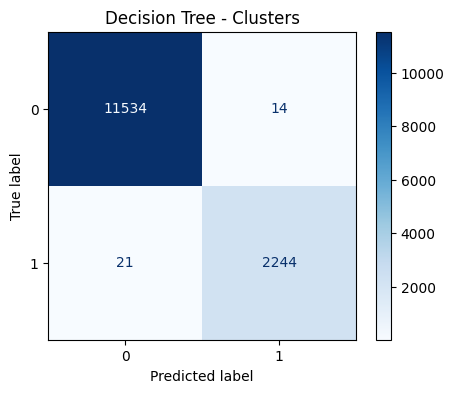

In [47]:
display_confusion_matrix(cm, 'Decision Tree - Clusters', tree_test)

In [48]:
print_classification_report(cm)

Accuracy: 0.9974661550713096
True negatives: 11534
False positives: 14
False negatives: 21
True positives: 2244
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11548
           1       0.99      0.99      0.99      2265

    accuracy                           1.00     13813
   macro avg       1.00      0.99      1.00     13813
weighted avg       1.00      1.00      1.00     13813



### References
> https://gist.github.com/vineethm1627/982c6d708db859d78541dbbcd744240a
>